In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sympy import (symbols, simplify, Matrix, diff, lambdify)
from sympy.physics.mechanics import dynamicsymbols, init_vprinting
from sympy.physics.mechanics import Lagrangian, ReferenceFrame, Point, Particle,inertia, RigidBody

from chords.symbolic import lagrange, diff_to_symb, SimpLagrangesMethod
from chords.numpy import unpack
from chords.symbolic import LagrangesMethod

In [3]:
from functools import lru_cache
from copy import copy

In [4]:
from chords.symbolic import printer_function
np_print = printer_function('np')

In [5]:
def hideticks():
    plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left = False,
        labelleft = False,
        labelbottom=False) # labels along the bottom edge are off

In [6]:
problem_name = 'Sinthetic Data'

In [7]:
#SymPy vector-like latex rendering inizialization:

init_vprinting()

In [8]:
def integrate_hs_step(x0, xd0, xdc, xd1, h):
    return x0 + h * (xd0 + 4*xdc + xd1)/6

def integrate_hs(x0, xd_arr, xdc_arr, h):
    x_arr = [x0,]
    for ii in range(xd_arr.shape[0]-1):
        x_current = x_arr[-1]
        x_arr.append(
            integrate_hs_step(x_current, xd_arr[ii], xdc_arr[ii], xd_arr[ii+1], h)
        )
    return np.array(x_arr)

def hs_central_points(x_arr, x_d_arr, h):
    x = x_arr[:-1]
    x_n = x_arr[1:]
    x_d = x_d_arr[:-1]
    x_d_n = x_d_arr[1:]
    
    x_c = (x + x_n) / 2 + h / 8 * (x_d - x_d_n)
    
    return x_c

In [9]:
def integ_2_3(q, q_c, qd0, qdd0, qddd0, h):
    
    qd = np.zeros_like(q)
    qd_c = np.zeros_like(q_c)
    qdd = np.zeros_like(q)
    qdd_c = np.zeros_like(q_c)
    qddd = np.zeros_like(q)
    qddd_c = np.zeros_like(q_c)
    
    N = q.shape[0]
    qd[0] = qd0
    qdd[0] = qdd0
    qddd[0] = qddd0
    
    for ii in range(N-1):
        a = q[ii]
        b = q_c[ii]
        c = q[ii+1]
        
        d = 2*(3*a - 4*b + c + h*qd[ii])/h**3
        e = (-4*a + 8*b - 4*c + 3*d*h**3 + h**2*qdd[ii])/h**4
        f = (1/3)*(-6*d + 9*e*h + qddd[ii])/h**2
        
        qd_c[ii] = -a/h + c/h - 1/4*d*h**2 - 1/8*e*h**3 - 1/16*f*h**4
        qd[ii+1] = a/h - 4*b/h + 3*c/h + (1/2)*d*h**2 + (1/2)*e*h**3 + (1/2)*f*h**4
        
        qdd_c[ii] = 4*a/h**2 - 8*b/h**2 + 4*c/h**2 - 1/2*e*h**2 - 1/2*f*h**3
        qdd[ii+1] = 4*a/h**2 - 8*b/h**2 + 4*c/h**2 + 3*d*h + 4*e*h**2 + 5*f*h**3
        
        qddd_c[ii] = 6*d + 3*e*h
        qddd[ii+1] = 6*d + 15*e*h + 27*f*h**2
        
    return qd, qd_c, qdd, qdd_c, qddd, qddd_c

In [10]:
from chords.piecewise import get_x_divisions, itemequal, reunite_matrix
from math import factorial as fac

def generate_hs_m_funcs(order):
    M = order  # in order to keep the paper naming
    q_coefs = np.zeros(order)
    for i in range(order):
        q_coefs[i] = 1 / fac(i)
    q_coefs_c = np.zeros(order - 1)
    for i in range(order - 1):
        q_coefs_c[i] = 1 / (2**i * fac(i))
    g_coefs = np.zeros(order + 1)
    g_coefs_c = np.zeros([order + 1, 5])
    for l in range(1, order + 1):
        g_coefs[l] = fac(l + 2)
        g_coefs_c[l, 0] = 2**l * fac(l) * (l + 2)
        g_coefs_c[l, 1] = 2 * l**2 + 4 * l - 3
        g_coefs_c[l, 2] = 2 ** (l + 1) * fac(l + 2)
        g_coefs_c[l, 3] = 2 * l**2 + 2 * l - 1
        g_coefs_c[l, 4] = -2 * l - 1

    def hs_m_half_x(x, x_n, a, a_n, dt):
        x_c = copy(x)
        x_list = get_x_divisions(x, order)
        x_n_list = get_x_divisions(x_n, order)
        x_c_list = get_x_divisions(x_c, order)
        v = x_list[-1]  # V represents here the highest q derivative contained in x
        v_n = x_n_list[-1]
        for l in range(1, M + 1):
            _t = dt ** (l - 1) / g_coefs_c[l, 0] * (
                3 * v_n + g_coefs_c[l, 1] * v
            ) + dt**l / g_coefs_c[l, 2] * (
                g_coefs_c[l, 3] * a + g_coefs_c[l, 4] * a_n
            )
            itemequal(x_c_list[M - l], _t)
            for i in range(l - 1):
                _t = x_c_list[M - l] + dt**i * q_coefs_c[i] * x_list[i + M - l]
                itemequal(x_c_list[M - l], _t)
        reunite_matrix(x_c, x_c_list, order)
        return x_c

    def hs_m_xn(x, a, a_n, dt, a_c):
        res = copy(x)
        x_list = get_x_divisions(x, order)
        res_list = get_x_divisions(res, order)
        for l in range(1, M + 1):
            _t = dt**l / g_coefs[l] * (l**2 * a + 4 * l * a_c + (2 - l) * a_n)
            itemequal(res_list[M - l], _t)
            for i in range(l):
                _t = res_list[M - l] + dt**i * q_coefs[i] * x_list[i + M - l]
                itemequal(res_list[M - l], _t)
        reunite_matrix(res, res_list, order)
        return res

    return hs_m_half_x, hs_m_xn

def hs_integ(x0, a_arr, a_c_arr, dt):
    
    if len(a_arr.shape) == 2:
        n_q = a_arr.shape[1]
    elif len(a_arr.shape) == 1:
        n_q = 1
    else:
        raise ValueError
        
    order = x0.shape[-1] // n_q
    
    hs_m_half_x, hs_m_xn = generate_hs_m_funcs(order)
    
    N = a_arr.shape[0]
    
    x_arr = np.zeros([N, order*n_q])
    x_d_arr = np.zeros([N, order*n_q])
    x_c_arr = np.zeros([N-1, order*n_q])
    x_d_c_arr = np.zeros([N-1, order*n_q])
    
    x_arr[0] = x0
    
    for ii in range(N-1):
        x_s = x_arr[ii]
        a_s = a_arr[ii]
        a_n = a_arr[ii+1]
        a_c = a_c_arr[ii]
        
        x_n = hs_m_xn(x_s, a_s, a_n, dt, a_c)
        x_c = hs_m_half_x(x_s, x_n, a_s, a_n, dt)
        
        x_arr[ii+1] = x_n
        x_c_arr[ii] = x_c
    
    x_d_arr[:,-n_q:] = a_arr
    x_d_c_arr[:,-n_q:] = a_c_arr
    
    x_d_arr[:,:-n_q] = x_arr[:,n_q:]
    x_d_c_arr[:,:-n_q] = x_c_arr[:,n_q:]
    
    return x_arr, x_c_arr, x_d_arr, x_d_c_arr

In [11]:
def get_jerk_impulse(v, v_c, h=1):
    
    # first segment, end slope:
    a1 = v[:-2, :]
    b1 = v_c[:-1, :]
    c1 = v[1:-1, :]

    s1 = a1 - 4*b1 + 3*c1

    # second segment, start slope:

    a2 = v[1:-1, :]
    b2 = v_c[1:, :]
    c2 = v[2:, :]

    s2 = -3*a2 + 4*b2 - c2

    jump = (s2-s1)/h
    return jump

def end_parab_slope(v, v_c, h=1):
    
    # first segment, end slope:
    a1 = v[:-2, :]
    b1 = v_c[:-1, :]
    c1 = v[1:-1, :]

    s1 = a1 - 4*b1 + 3*c1
    
    return s1/h
        
def get_jerk_heights(v, v_c, h=1):
    # first segment, :
    a = v[:-2, :]
    b = v_c[:-1, :]
    c = v[1:-1, :]

    j = 4*(a - 2*b + c)/(h**2)
    return j

In [10]:
from chords.opti import Opti_Problem
from chords.analysis import interpolation, dynamic_errors
import time
from functools import lru_cache
from chords.numpy import store_results

In [11]:
from casadi import sum1, sum2

In [12]:
from chords.util import (sch_to_lab, sch_to_color, sch_to_long_label, scheme_kwargs, oct_fig_size, 
                         set_fonts, save_fig, plot_by_segments)
from chords.casadi import implicit_dynamic_x_to_casadi_function, sympy2casadi
from chords.piecewise import interp_2d

set_fonts()

In [13]:

from chords.piecewise import interpolated_array, interpolated_array_derivative

In [14]:
def plot_colloc_points(scheme, _res):
    N = len(_res["t"])
    plt.plot([],
        [],
        "ok",
        ms=5,
        label="knot & collocation points",
    )
    if "hs" in scheme:
        plt.plot(
            [],
            [],
            "ow",
            ms=5,
            markeredgecolor="k",
            label="collocation points",
        )

# Generación de Datos

### HS scheme: Order 1

In [17]:
q0 = np.array([0.])

In [18]:
qd_ej = np.array([
    [0.5,],
    [1,],
    [0.,],
])
qd_c_ej = np.array([
    [-1.,],
    [0.7,],
])

In [19]:
qd_ej, qd_c_ej

(array([[0.5],
        [1. ],
        [0. ]]),
 array([[-1. ],
        [ 0.7]]))

In [20]:
q = integrate_hs(
    x0= q0,
    xd_arr=qd_ej,
    xdc_arr=qd_c_ej,
    h = 1
)

q_c = hs_central_points(
    x_arr= q, 
    x_d_arr=qd_ej,
    h=1
)
q, q_c

(array([[ 0.        ],
        [-0.41666667],
        [ 0.21666667]]),
 array([[-0.27083333],
        [ 0.025     ]]))

qd, qd_c, qdd, qdd_c, qddd, qddd_c = integ_2_3(
    q = q,
    q_c = q_c,
    qd0 = qd_ej[0],
    qdd0 = np.array([5.]),
    qddd0 = np.array([10.]),
    h = 1,
)

np.round(qdd_c, 2), np.round(qdd, 2)

np.round(qddd_c, 2), np.round(qddd, 2)

(integrate_hs(
    x0= np.array([5.]),
    xd_arr=qddd,
    xdc_arr=qddd_c,
    h = 1
), 
hs_central_points(
    x_arr= qdd, 
    x_d_arr=qddd,
    h=1
))

x = np.concatenate((q, qd, qdd), axis=1)
xd = np.concatenate((qd, qdd, qddd), axis=1)
x_c = np.concatenate((q_c, qd_c, qdd_c), axis=1)
xd_c = np.concatenate((qd_c, qdd_c, qdd_c), axis=1)

np.round(x), np.round(xd), np.round(x_c), np.round(xd_c)

In [21]:
x_1 = np.concatenate((q, qd_ej, q), axis=1)
xd_1 = np.concatenate((qd_ej, q, qd_ej), axis=1)
x_c_1 = np.concatenate((q_c, qd_c_ej, q_c), axis=1)
xd_c_1 = np.concatenate((qd_c_ej, q_c, qd_c_ej), axis=1)

x_1, xd_1, x_c_1, xd_c_1

(array([[ 0.        ,  0.5       ,  0.        ],
        [-0.41666667,  1.        , -0.41666667],
        [ 0.21666667,  0.        ,  0.21666667]]),
 array([[ 0.5       ,  0.        ,  0.5       ],
        [ 1.        , -0.41666667,  1.        ],
        [ 0.        ,  0.21666667,  0.        ]]),
 array([[-0.27083333, -1.        , -0.27083333],
        [ 0.025     ,  0.7       ,  0.025     ]]),
 array([[-1.        , -0.27083333, -1.        ],
        [ 0.7       ,  0.025     ,  0.7       ]]))

### HS scheme: Order 3

In [22]:
x0= np.array([0.,0.,-0.2])
qd_ej = np.array([
    [-0.5,],
    [-1,],
    [0.,],
])
qd_c_ej = np.array([
    [1.,],
    [-0.7,],
])
 
x, x_c, xd, xd_c = hs_integ(
    x0= x0,
    a_arr= qd_ej,
    a_c_arr= qd_c_ej,
    dt= 1)


q = x[:,:1]
q_c = x_c[:,:1]
qd = x[:,1:2]
qd_c = x_c[:,1:2]
x, x_c, xd, xd_c

(array([[ 0.        ,  0.        , -0.2       ],
        [-0.02916667,  0.05      ,  0.21666667],
        [-0.01583333, -0.13333333, -0.41666667]]),
 array([[-0.02213542, -0.06354167,  0.07083333],
        [ 0.00302083,  0.04166667, -0.225     ]]),
 array([[ 0.        , -0.2       , -0.5       ],
        [ 0.05      ,  0.21666667, -1.        ],
        [-0.13333333, -0.41666667,  0.        ]]),
 array([[-0.06354167,  0.07083333,  1.        ],
        [ 0.04166667, -0.225     , -0.7       ]]))

### Trapz scheme: Order 1

In [23]:
qd_ej_t = np.array([
    [0.5,],
    [-1,],
    [0.3,],
])

qd_trapz_c_t =  (qd_ej_t[:-1] + qd_ej_t[1:])/2
q_t = integrate_hs(
    x0= q0,
    xd_arr=qd_ej_t,
    xdc_arr=qd_trapz_c_t,
    h = 1
)

q_c_t = hs_central_points(
    x_arr= q_t, 
    x_d_arr=qd_ej_t,
    h=1
)
q_t, q_c_t

(array([[ 0.  ],
        [-0.25],
        [-0.6 ]]),
 array([[ 0.0625],
        [-0.5875]]))

In [24]:
x_1_t = np.concatenate((q_t, qd_ej_t, q_t), axis=1)
xd_1_t = np.concatenate((qd_ej_t, q_t, qd_ej_t), axis=1)
x_c_1_t = np.concatenate((q_c_t, qd_trapz_c_t, q_c_t), axis=1)
xd_c_1_t = np.concatenate((qd_trapz_c_t, q_c_t, qd_trapz_c_t), axis=1)

x_1_t, xd_1_t, x_c_1_t, xd_c_1_t

(array([[ 0.  ,  0.5 ,  0.  ],
        [-0.25, -1.  , -0.25],
        [-0.6 ,  0.3 , -0.6 ]]),
 array([[ 0.5 ,  0.  ,  0.5 ],
        [-1.  , -0.25, -1.  ],
        [ 0.3 , -0.6 ,  0.3 ]]),
 array([[ 0.0625, -0.25  ,  0.0625],
        [-0.5875, -0.35  , -0.5875]]),
 array([[-0.25  ,  0.0625, -0.25  ],
        [-0.35  , -0.5875, -0.35  ]]))

### Trapz scheme: Order 3

In [25]:
x0= np.array([0.08333333, 0.13333333, -0.35 ])
qd_ej = np.array([
    [-0.3,],
    [1,],
    [-0.5,],
])

a_trapz_c =  (qd_ej[:-1] + qd_ej[1:])/2
 
x_t, x_c_t, xd_t, xd_c_t = hs_integ(
    x0= x0,
    a_arr= qd_ej,
    a_c_arr= a_trapz_c,
    dt= 1)


q_t = x_t[:,:1]
q_c_t = x_c_t[:,:1]
qd_t = x_t[:,1:2]
qd_c_t = x_c_t[:,1:2]
x_t, x_c_t, xd_t, xd_c_t

(array([[ 8.33333300e-02,  1.33333330e-01, -3.50000000e-01],
        [ 4.58333267e-02, -1.50000003e-01, -5.55111512e-17],
        [-9.99999999e-09,  9.99999967e-02,  2.50000000e-01]]),
 array([[ 0.10338541, -0.05208334, -0.3375    ],
        [-0.01223959, -0.05625   ,  0.3125    ]]),
 array([[ 1.33333330e-01, -3.50000000e-01, -3.00000000e-01],
        [-1.50000003e-01, -5.55111512e-17,  1.00000000e+00],
        [ 9.99999967e-02,  2.50000000e-01, -5.00000000e-01]]),
 array([[-0.05208334, -0.3375    ,  0.35      ],
        [-0.05625   ,  0.3125    ,  0.25      ]]))

# Clasificación de datos según caso

In [26]:
order = 1
scheme = 'hsn_parab'#'trapz_n'#
params =[]

if 'trap' in scheme:
    if order == 3:
        q_sol = q_t
        q_sol_c = q_c_t
        x_sol = x_t
        x_sol_c = x_c_t
        x_sol_d = xd_t
        x_sol_d_c = xd_c_t
        v = qd_t
        v_c = qd_c_t
    else:
        q_sol = x_1_t
        q_sol_c = x_c_1_t
        x_sol = x_1_t
        x_sol_c = x_c_1_t
        x_sol_d = xd_1_t
        x_sol_d_c = xd_c_1_t
        v = xd_1_t
        v_c = xd_c_1_t
else:
    if order == 3:
        q_sol = q
        q_sol_c = q_c
        x_sol = x
        x_sol_c = x_c
        x_sol_d = xd
        x_sol_d_c = xd_c
        v = qd
        v_c = qd_c
    else:
        q_sol = x_1
        q_sol_c = x_c_1
        x_sol = x_1
        x_sol_c = x_c_1
        x_sol_d = xd_1
        x_sol_d_c = xd_c_1
        v = xd_1
        v_c = xd_c_1
    
_res = {
    #'N':2,
    't':np.array([0.,1.,2.]),
    't_c': np.array([0.5, 1.5]),
    'x': x_sol,
    'x_d':x_sol_d,
    'x_c':x_sol_c,
    'x_d_c':x_sol_d_c,
    'q': q_sol,
    'q_c':q_sol_c,
    'v':v,
    'v_c':v_c,
    'solve_order':order,
    'scheme_mode':'equispaced',
    'scheme': scheme,
    'params':params,
    'u':v,
    'u_c': v_c
}

if 'hs' in scheme:
    title_scheme = 'HS-'
else:
    title_scheme = 'TZ-'
    
scheme_col = scheme
if order == 1:
    if 'hs' in scheme:
        scheme_col = 'hs'
    else:
        scheme_col = 'trapz'

color = sch_to_color(scheme_col)

In [27]:
n_col = 2
model = 'impl_diff'

plot_n = 1013
t_interp = np.linspace(0, 2, plot_n)
#tau_interp = np.linspace(-1,1,plot_n)
dt = (_res['t'][-1]-_res['t'][0])/n_col


interpolations = interpolation(
    _res,
    problem_order = 3,
    scheme_order=3,
    x_interp=None,
    u_interp=None,
    n_interp=plot_n,
)


q_interp =interpolations['q']#[:, :3]
v_interp =interpolations['v']#[:, 3:6]
a_interp =interpolations['a']#[:, 6:]
j_interp =interpolations['jerk']#[:, 6:]
w_interp =interpolations['u']

q_d_interp = interpolations['q_d']#[:, :3]
q_dd_interp = interpolations['q_d_d']#[:, :3]
q_ddd_interp = interpolations['q_d_d_d']#[:, :3]



if model == 'impl_diff':
    _res_a = _res['x'][:,-1:]
    _res_j = _res['x_d'][:,-1:]
    _res_a_c = _res['x_c'][:,-1:]
    _res_j_c = _res['x_d_c'][:,-1:]
else:
    raise ValueError()
    


#if 'hs' in scheme:
jerk_impulses = get_jerk_impulse(
    v = _res['x_d'][:,:1],
    v_c = _res['x_d_c'][:,:1],
    h = 2/n_col
)

jerk_heights = get_jerk_heights(
    v = _res['x_d'][:,:1],
    v_c = _res['x_d_c'][:,:1],
    h = 2/n_col
)

slope_pos = end_parab_slope(
    v = _res['x_d'][:,:1],
    v_c = _res['x_d_c'][:,:1],
    h = 2/n_col
)
    
jerk_scale = np.max(q_ddd_interp[:,:1]) - np.min(q_ddd_interp[:,:1])
impulse_scale = np.max(np.abs(jerk_impulses))
scale_factor = max(0.2 * jerk_scale/impulse_scale, 0.01)
jerk_scale, impulse_scale

In [28]:
dt

In [29]:
save = True#False
save_format = 'pdf'
marker_size = 30
line_width = 4
titlesize = 50
plt.rcParams['axes.titlepad'] = 20  # pad is in points

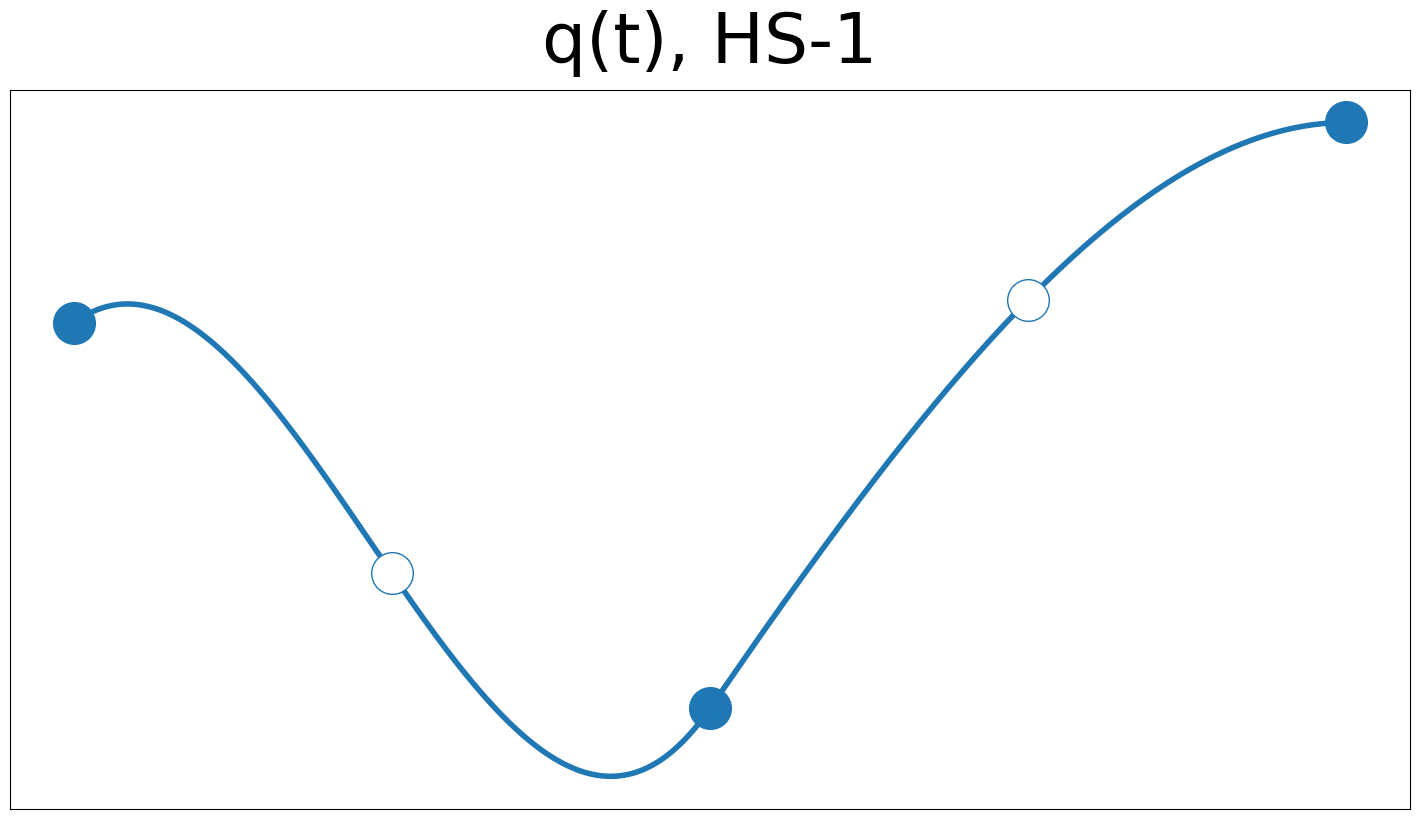

In [30]:
plt.figure(figsize=[14,8])
labels= ['q(t)', r'$\theta$(t)']
for ii in range(1):
    plt.plot(t_interp, q_interp[:,ii], c = color, lw = line_width, label = labels[ii])
    plt.plot(_res['t'],_res['q'][:,ii], 'o', c = color, ms =marker_size)
    if 'hs' in scheme: 
        plt.plot(_res['t_c'],_res['q_c'][:,ii],
                 'o', mec = color, ms =marker_size, mfc = 'w',
                # label = labels[ii] + '_c'
                )
#plt.plot(t_ref, q_ref, ':')



#save = True#False#

    
#plt.grid()
#plt.legend()
plt.title(r'q(t)' + f', {title_scheme}{order}', fontsize=titlesize)
hideticks()
plt.tight_layout(pad=0.0)

if save:
        save_fig(
            problem_name = problem_name,
            graph_name = 'q',
            schemes_printed = [scheme],
            save_format = save_format,
            N = n_col,
            q_counter = None,
            add = f'HS{order}'
        )

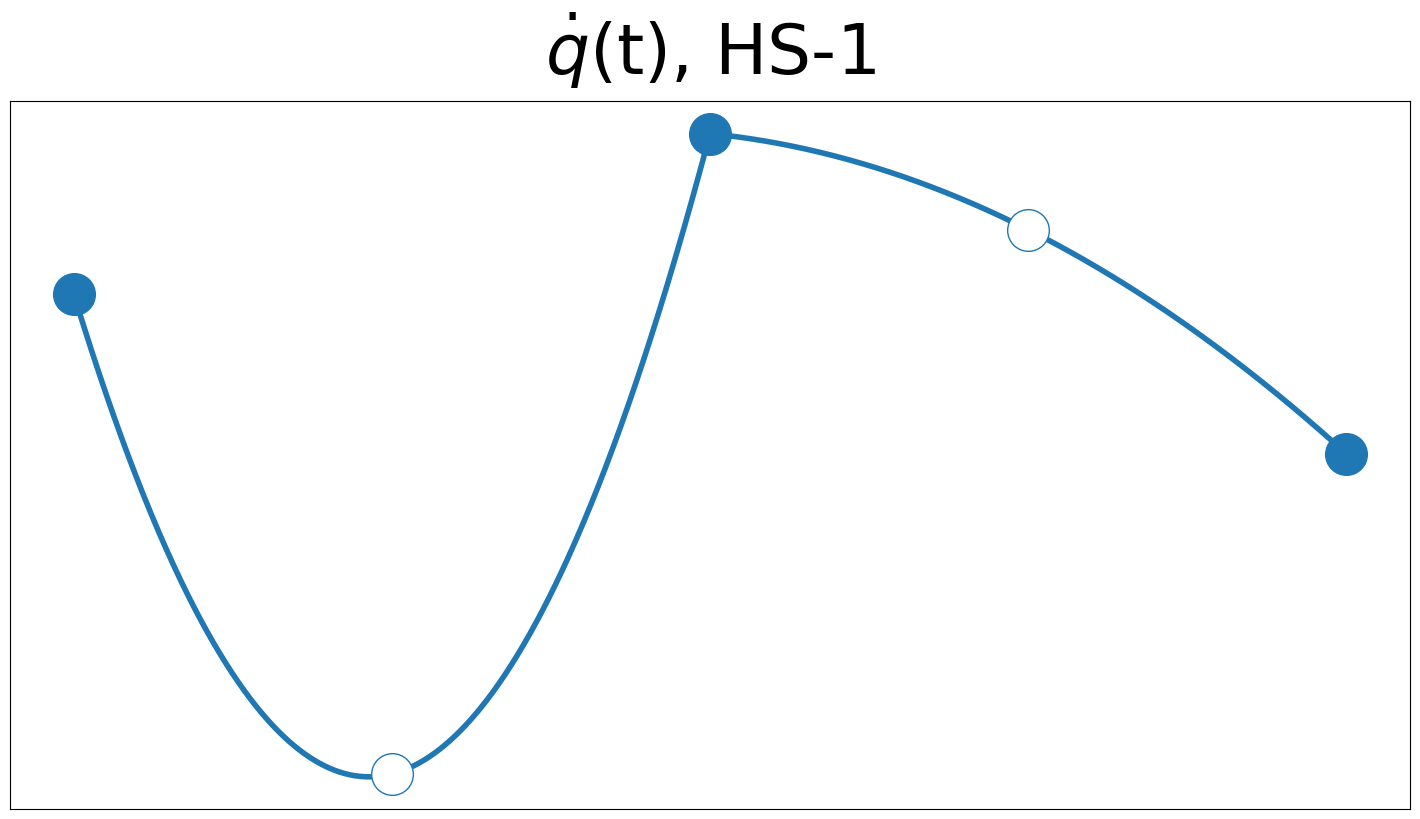

In [31]:
plt.figure(figsize=[14,8])
labels= [r'$\dot{q}$(t)', r'$\dot{\theta}$(t)']
for ii in range(1):
    plt.plot(t_interp, q_d_interp[:,ii], c = color, lw = line_width, label = labels[ii])
    plt.plot(_res['t'],_res['v'][:,ii], 'o', c = color, ms =marker_size)
    if 'hs' in scheme: 
        plt.plot(_res['t_c'],_res['v_c'][:,ii],
                 'o', mec = color, ms =marker_size, mfc = 'w',
                #  label = labels[ii] + '_c'
                )
       

    
    
#plt.plot(t_ref, v_ref, ':')
#plt.grid()
#plt.legend()

hideticks()
plt.title(r'$\dot{q}$(t)' + f', {title_scheme}{order}', fontsize=titlesize)
plt.tight_layout(pad=0.0)


#save = True#False#
if save:
        save_fig(
            problem_name = problem_name,
            graph_name = 'q_dot',
            schemes_printed = [scheme],
            save_format = save_format,
            N = n_col,
            q_counter = None,
            add = f'HS{order}'
        )

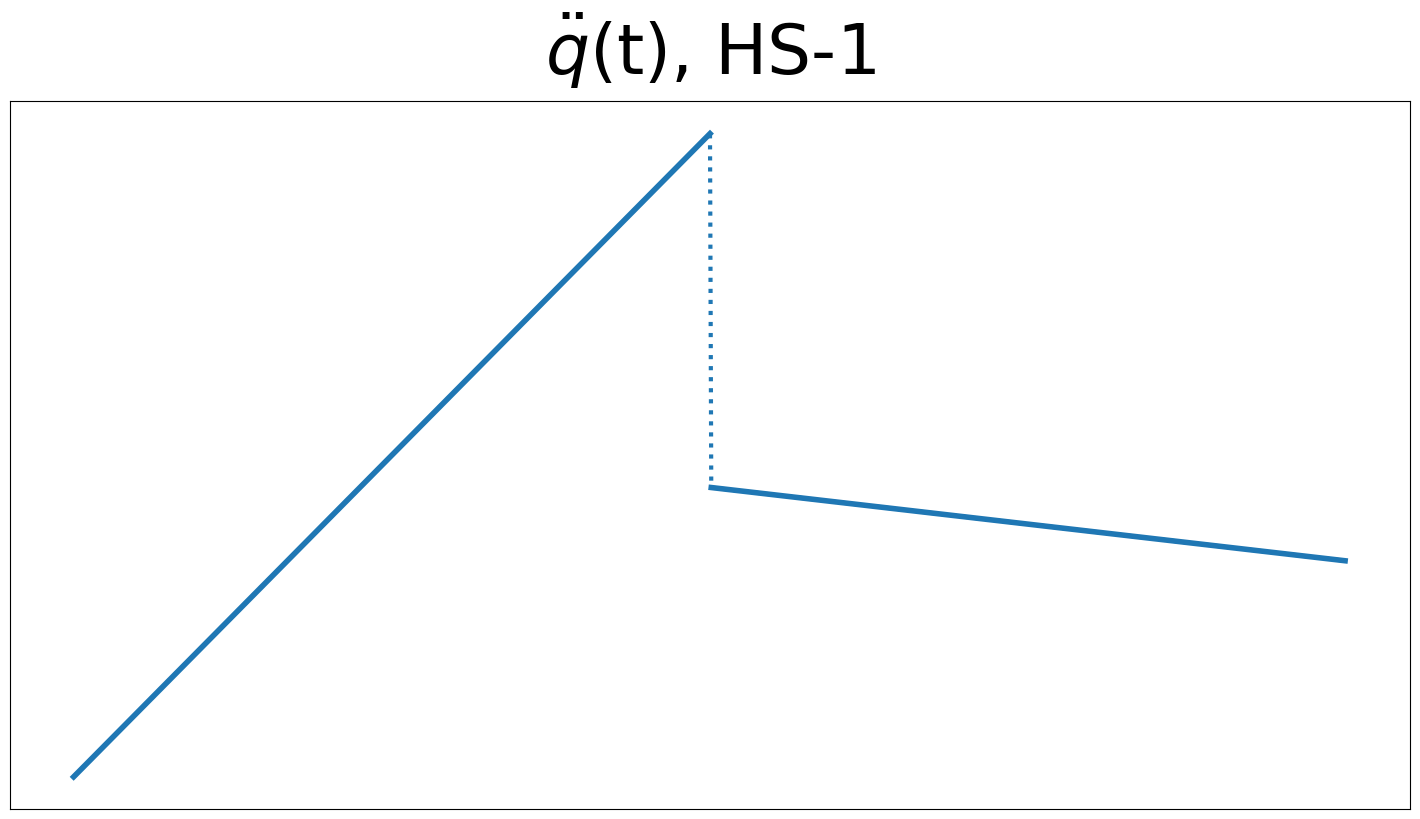

In [32]:
plt.figure(figsize=[14,8])
labels= [r'$\ddot{q}$(t)', r'$\ddot{\theta}$(t)']
for ii in range(1):
    plot_by_segments(
        t_arr = t_interp,
        y_plot = q_dd_interp[:,ii],
        label = labels[ii],
        N = n_col,
        end_t = 2,
        plot_dict = {
            'c': color,
            'lw':line_width,
        }
    )
    if False:
        for kk in range(len(jerk_impulses)):
            plt.arrow(
                _res['t'][1+kk],
                slope_pos[kk,ii],
                0,
                jerk_impulses[kk,ii],
                color = 'w',
                width = 0.01,
                length_includes_head=True,
                head_length = 0.4*abs(jerk_impulses[kk,ii]),
                ec = color
            )
    #plt.plot(t_interp, q_dd_interp[:,ii], c = 'grey')
    if order == 3:
        plt.plot(_res['t'],_res_a[:,ii], 'o', ms =marker_size, c = color,label = labels[ii])
        if 'hs' in scheme: 
            plt.plot(_res['t_c'],_res_a_c[:,ii],
                     'o', mec = color, ms =marker_size, mfc = 'w',
                     label = labels[ii] + '_c')
    else:
           
        plt.plot(t_interp, q_dd_interp[:,ii], c = color, ls= ':',lw = line_width*0.75)
        
        
if 'trap' in scheme and order == 1:
    plt.ylim([-2.5, 2.3])



#plt.plot(t_ref, a_ref, ':', c='k', label = 'HS3 ref sol')
#plt.grid()
#plt.legend()

hideticks()

plt.title(r'$\ddot{q}$(t)' + f', {title_scheme}{order}', fontsize=titlesize)
plt.tight_layout(pad=0.0)

#save = True#False#
if save:
    save_fig(
        problem_name = problem_name,
        graph_name = 'q_dot_dot',
        schemes_printed = [scheme],
        save_format = save_format,
        N = n_col,
        q_counter = None,
        add = f'HS{order}'
    )

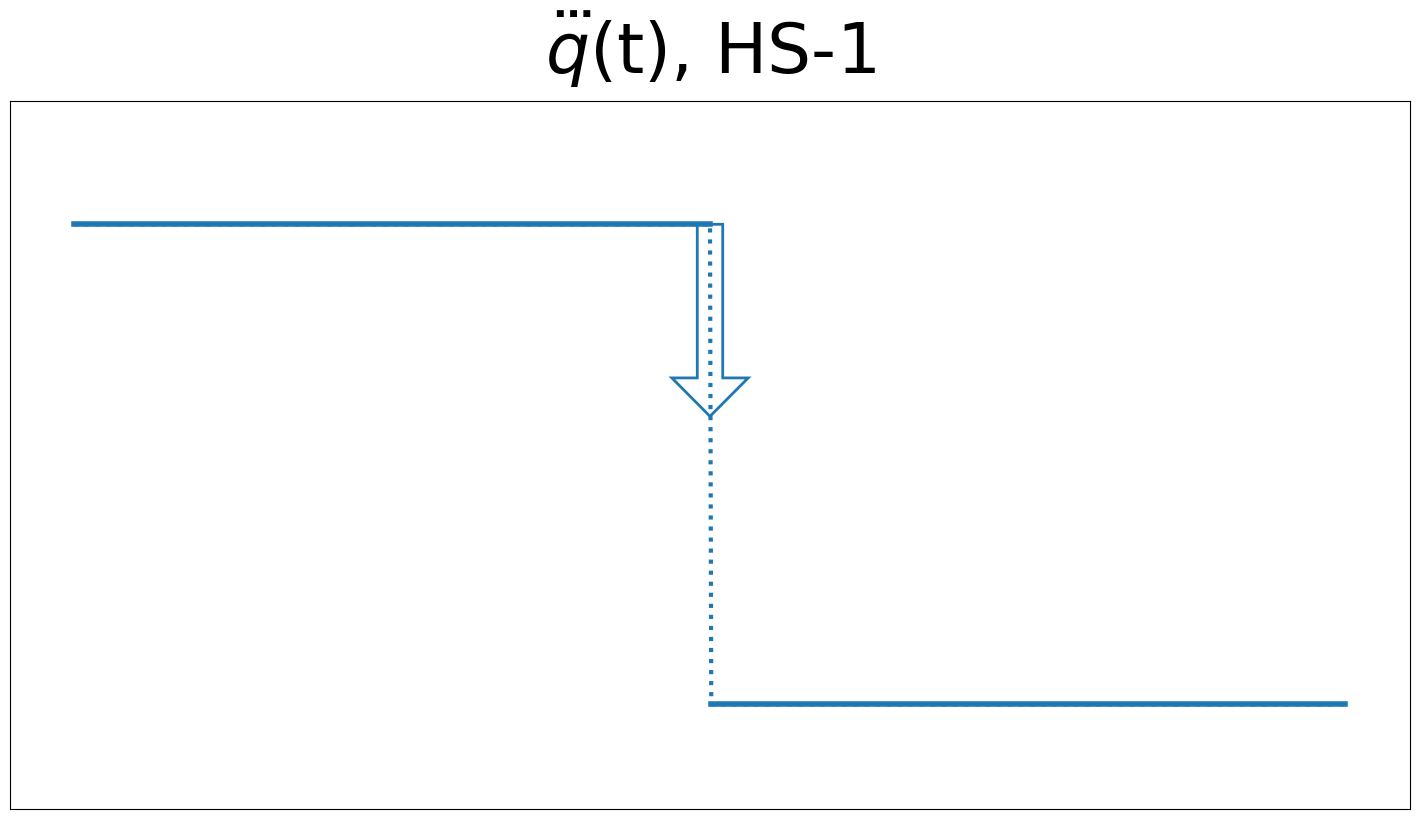

In [33]:
plt.figure(figsize=[14,8])
labels= [r'$\dddot{q}$(t)', r'$\dddot{\theta}$(t)']
for ii in range(1):
    #plt.plot(t_interp, q_ddd_interp[:,ii], c = 'grey')
    plot_by_segments(
        t_arr = t_interp,
        y_plot = q_ddd_interp[:,ii],
        label = labels[ii],
        N = n_col,
        end_t = 2,
        plot_dict = {
            'c': color,
            'lw':line_width,
        }
    )
    
    if order ==1 :
        for kk in range(len(jerk_impulses)):
            plt.arrow(
                _res['t'][1+kk],
                jerk_heights[kk,ii],
                0,
                2*scale_factor*jerk_impulses[kk,ii],
                color = 'w',
                width = 0.04,
                length_includes_head=True,
                head_length = scale_factor*0.4*abs(jerk_impulses[kk,ii]),
                ec = color,
                lw = line_width/2
            )
        if 'hs' in scheme:
            plt.ylim([-5,18])
        else:
            plt.ylim([-0.02,0.07])
        plt.plot(t_interp, q_ddd_interp[:,ii], c = color, ls= ':',lw = line_width*0.75)
    
    if order == 3:
        plt.plot(_res['t'],_res_j[:,ii], 'o', c = color, ms =marker_size, label = labels[ii])
        if 'hs' in scheme: 
            plt.plot(_res['t_c'],_res_j_c[:,ii],
                     'o', mec = color, ms =marker_size, mfc = 'w',
                     label = labels[ii] + '_c')

        
#plt.plot(t_ref, j_ref, ':')
#plt.grid()
#plt.legend()

hideticks()

plt.title(r'$\dddot{q}$(t)' + f', {title_scheme}{order}', fontsize=titlesize)
plt.tight_layout(pad=0.0)

#save = True#False#
if save:
        save_fig(
            problem_name = problem_name,
            graph_name = 'q_dot_dot_dot',
            schemes_printed = [scheme],
            save_format = save_format,
            N = n_col,
            q_counter = None,
            add = f'HS{order}'
        )

# Color Testing

In [9]:

from matplotlib import colormaps
from chords.util import sch_to_lab

In [10]:
schemes = [
    'hs_parab',
    'hs_mod_parab',
    'trapz',
    'trapz_mod',
    'LG',
    'BU_LG',
    'TD_LG',
    'LGR',
    'BU_LGR',
    'TD_LGR',
    'LGL',
    'BU_LGL',
    'TD_LGL',
]

In [11]:
def sch_to_color(sch):
    color_dict = {}
    piece_sch = [
        "hs",
        "trapz_mod",
        "trapz",
        "hs_mod",
        "hsj",
        "rk4",
        "hsj_mod",
    ]
    pseud_sch = ["LG", "LGL", "LGR", "JG", "JGR", "JGL", "CG", "CGL", "CGR", "LG2"]
    n_sch = len(pseud_sch)

    for ii, sc_name in enumerate(piece_sch):
        color_dict[sc_name] = f"C{ii}"

    for ii, sc_name in enumerate(pseud_sch):
        color_dict[sc_name] = f"C{ii+4}"

    c_ch = colormaps["cubehelix"](np.linspace(0.2, 0.9, n_sch))
    c_gp2 = colormaps["gnuplot2"](np.linspace(0.85, 0.2, n_sch))
    
    for ii, sc_name in enumerate(pseud_sch):
        color_dict["BU_" + sc_name] = c_ch[ii]    
    for ii, sc_name in enumerate(pseud_sch):
        color_dict["TD_" + sc_name] = c_gp2[ii]
    
    color_dict['BU_LG'] = colormaps["cubehelix"](0.45)
    color_dict['TD_LG'] = colormaps["gist_stern"](0.12)
    
    color_dict['BU_LGR'] = colormaps["gnuplot2"](0.2)
    color_dict['TD_LGR'] = colormaps["terrain"](0.6)
    
    color_dict['BU_LGL'] = colormaps["cubehelix"](0.7)
    color_dict['TD_LGL'] = colormaps["cubehelix"](0.3)

    sch = sch.replace("_parab", "")
    sch = sch.replace("_inv", "")
    sch = sch.replace("trapz_n", "trapz_mod")
    sch = sch.replace("hsn", "hs_mod")
    # sch = sch.replace("BU_", "")
    # sch = sch.replace("TD_", "")
    return color_dict[sch]

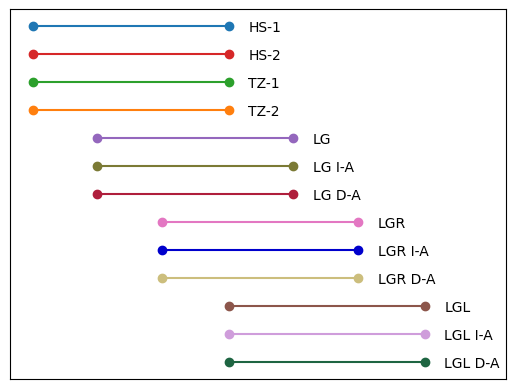

In [12]:
for ii, scheme in enumerate(schemes):
    if 0 <= ii <= 3:
        m = 0
    elif 4 <= ii <= 6:
        m = 0.33
    elif 7 <= ii <= 9:
        m = 0.66
    elif 10 <= ii <= 12:
        m = 1
    plt.plot([m,m+1], [-ii,-ii],marker='o', c = sch_to_color(scheme), label = scheme)
    
    plt.text(m + 1.1, -ii-0.2, sch_to_lab(scheme))

plt.plot([2.3, 2.3], [-12, -12], 'k')
hideticks()

plt.savefig('color_palette_thesis.png')
#plt.legend()

# Pseudospectral schemes graphs

In [8]:
t_arr = np.linspace(-1,1,500)
y_arr = np.sin(t_arr*3)

In [16]:
from chords.pseudospectral import coll_points, node_points
from chords.util import sch_to_color, oct_fig_size, save_fig, sch_to_lab

In [10]:
N_col = 3
M = 2

lg_col = np.array(coll_points(N_col, 'LG'), dtype = float)
lgr_col = np.array(coll_points(N_col, 'LGR'), dtype = float)
lgl_col = np.array(coll_points(N_col, 'LGL'), dtype = float)


lg_nod = np.array(node_points(N_col+1, 'LG'), dtype = float)
lg_bu_nod = np.array(node_points(N_col+M, 'LGL'), dtype = float)
lgr_nod = np.array(node_points(N_col+1, 'LGR'), dtype = float)
lgl_nod = np.array(node_points(N_col, 'LGL'), dtype = float)

lg_col_y = np.sin(lg_col*3)
lgr_col_y = np.sin(lgr_col*3)
lgl_col_y = np.sin(lgl_col*3)

lg_nod_y = np.sin(lg_nod*3)
lgr_nod_y = np.sin(lgr_nod*3)
lgl_nod_y = np.sin(lgl_nod*3)
lg_bu_nod_y = np.sin(lg_bu_nod*3)

In [11]:
linewidth = 4
marker_size = 20
titlesize = 40
plt.rcParams['axes.titlepad'] = 20
save = True
save_format = 'pdf'

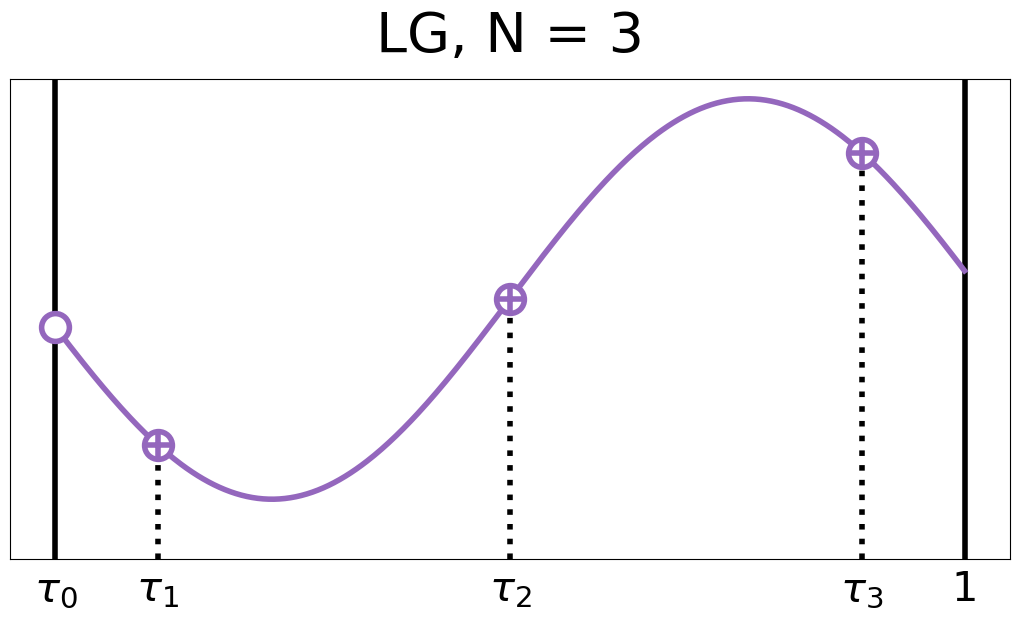

In [19]:
scheme = 'LG'

plt.figure(figsize=oct_fig_size)
plt.title(scheme + ', N = 3', fontsize=titlesize)
plt.tight_layout(pad=0.0)


plt.vlines([-1,1], [-1.3, -1.3], [1.1,1.1],
          lw = linewidth,
          color = 'k')
plt.vlines(lg_col, -1.3*np.ones_like(lg_col), lg_col_y,
          lw = linewidth,
          color = 'k',
          ls = ':')

plt.plot(t_arr, y_arr, 
         c = sch_to_color(scheme),
         lw = linewidth
        )
plt.plot(lg_nod, lg_nod_y,'o' ,
         mec = sch_to_color(scheme),
         ms = marker_size,
         mfc = 'w',
         mew = linewidth
        )

plt.plot(lg_col, lg_col_y,'+' ,
         mec = sch_to_color(scheme),
         ms = marker_size,
         mew = linewidth,
         mfc = sch_to_color(scheme),
        )
plt.ylim(-1.3, 1.1)
plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left = False,
        labelleft = False,
        labelbottom=True)

x_ticks = np.array(node_points(N_col+1, 'LG')+[1], dtype = float)
x_labels = [r'$\tau_'+str(ii)+'$' for ii in range(N_col+1)] + ['1']
plt.xticks(x_ticks, x_labels, fontsize = 30)

plt.tight_layout(pad=0.0)
if save:
        save_fig(
            problem_name = problem_name,
            graph_name = 'points',
            schemes_printed = [scheme],
            save_format = save_format,
            N = N_col,
            q_counter = None,
        )

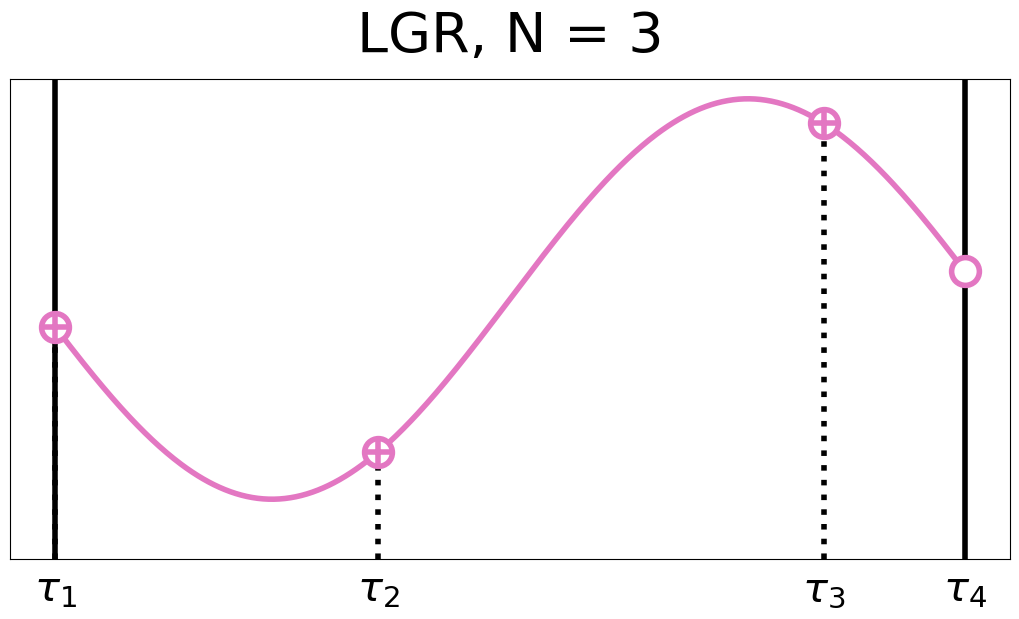

In [20]:
scheme = 'LGR'

plt.figure(figsize=oct_fig_size)
plt.title(scheme + ', N = 3', fontsize=titlesize)
plt.tight_layout(pad=0.0)


plt.vlines([-1,1], [-1.3, -1.3], [1.1,1.1],
          lw = linewidth,
          color = 'k')
plt.vlines(lgr_col, -1.3*np.ones_like(lgr_col), lgr_col_y,
          lw = linewidth,
          color = 'k',
          ls = ':')

plt.plot(t_arr, y_arr, 
         c = sch_to_color(scheme),
         lw = linewidth
        )
plt.plot(lgr_nod, lgr_nod_y,'o' ,
         mec = sch_to_color(scheme),
         ms = marker_size,
         mfc = 'w',
         mew = linewidth
        )

plt.plot(lgr_col, lgr_col_y,'+' ,
         mec = sch_to_color(scheme),
         ms = marker_size,
         mew = linewidth,
         mfc = sch_to_color(scheme),
        )
plt.ylim(-1.3, 1.1)
plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left = False,
        labelleft = False,
        labelbottom=True)

x_ticks = np.array(node_points(N_col+1, 'LGR'), dtype = float)
x_labels = [r'$\tau_'+str(ii+1)+'$' for ii in range(N_col+1)]
plt.xticks(x_ticks, x_labels, fontsize = 30)

plt.tight_layout(pad=0.0)
if save:
        save_fig(
            problem_name = problem_name,
            graph_name = 'points',
            schemes_printed = [scheme],
            save_format = save_format,
            N = N_col,
            q_counter = None,
        )

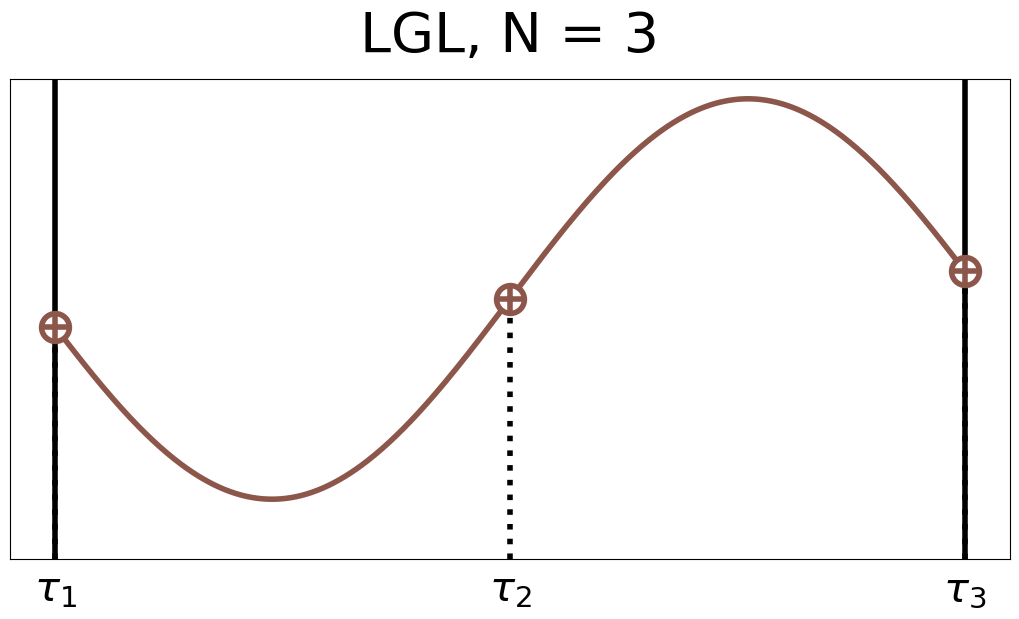

In [21]:
scheme = 'LGL'

plt.figure(figsize=oct_fig_size)
plt.title(scheme + ', N = 3', fontsize=titlesize)
plt.tight_layout(pad=0.0)


plt.vlines([-1,1], [-1.3, -1.3], [1.1,1.1],
          lw = linewidth,
          color = 'k')
plt.vlines(lgl_col, -1.3*np.ones_like(lgl_col), lgl_col_y,
          lw = linewidth,
          color = 'k',
          ls = ':')

plt.plot(t_arr, y_arr, 
         c = sch_to_color(scheme),
         lw = linewidth
        )
plt.plot(lgl_nod, lgl_nod_y,'o' ,
         mec = sch_to_color(scheme),
         ms = marker_size,
         mfc = 'w',
         mew = linewidth
        )

plt.plot(lgl_col, lgl_col_y,'+' ,
         mec = sch_to_color(scheme),
         ms = marker_size,
         mew = linewidth,
         mfc = sch_to_color(scheme),
        )
plt.ylim(-1.3, 1.1)
plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left = False,
        labelleft = False,
        labelbottom=True)

x_ticks = np.array(node_points(N_col, 'LGL'), dtype = float)
x_labels = [r'$\tau_'+str(ii+1)+'$' for ii in range(N_col)]
plt.xticks(x_ticks, x_labels, fontsize = 30)

plt.tight_layout(pad=0.0)
if save:
        save_fig(
            problem_name = problem_name,
            graph_name = 'points',
            schemes_printed = [scheme],
            save_format = save_format,
            N = N_col,
            q_counter = None,
        )

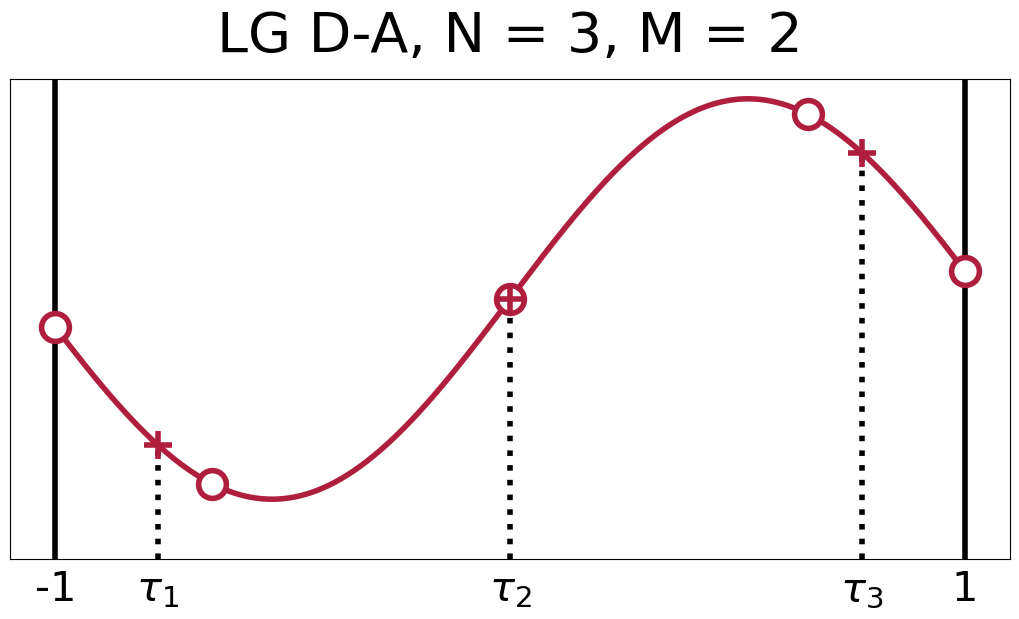

In [17]:
scheme = 'TD_LG'

plt.figure(figsize=oct_fig_size)
plt.title(sch_to_lab(scheme) + f', N = 3, M = {M}', fontsize=titlesize)
plt.tight_layout(pad=0.0)


plt.vlines([-1,1], [-1.3, -1.3], [1.1,1.1],
          lw = linewidth,
          color = 'k')
plt.vlines(lg_col, -1.3*np.ones_like(lg_col), lg_col_y,
          lw = linewidth,
          color = 'k',
          ls = ':')

plt.plot(t_arr, y_arr, 
         c = sch_to_color(scheme),
         lw = linewidth
        )
plt.plot(lg_bu_nod, lg_bu_nod_y,'o' ,
         mec = sch_to_color(scheme),
         ms = marker_size,
         mfc = 'w',
         mew = linewidth
        )

plt.plot(lg_col, lg_col_y,'+' ,
         mec = sch_to_color(scheme),
         ms = marker_size*1,
         mew = linewidth*1,
         mfc = sch_to_color(scheme),
        )
plt.ylim(-1.3, 1.1)
plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left = False,
        labelleft = False,
        labelbottom=True)

x_ticks = np.array(node_points(N_col+1, 'LG')+[1], dtype = float)
x_labels = [-1] + [r'$\tau_'+str(ii+1)+'$' for ii in range(N_col)] + ['1']
plt.xticks(x_ticks, x_labels, fontsize = 30)

plt.tight_layout(pad=0.0)
if save:
        save_fig(
            problem_name = problem_name,
            graph_name = 'points',
            schemes_printed = [scheme],
            save_format = save_format,
            N = N_col,
            q_counter = None,
        )

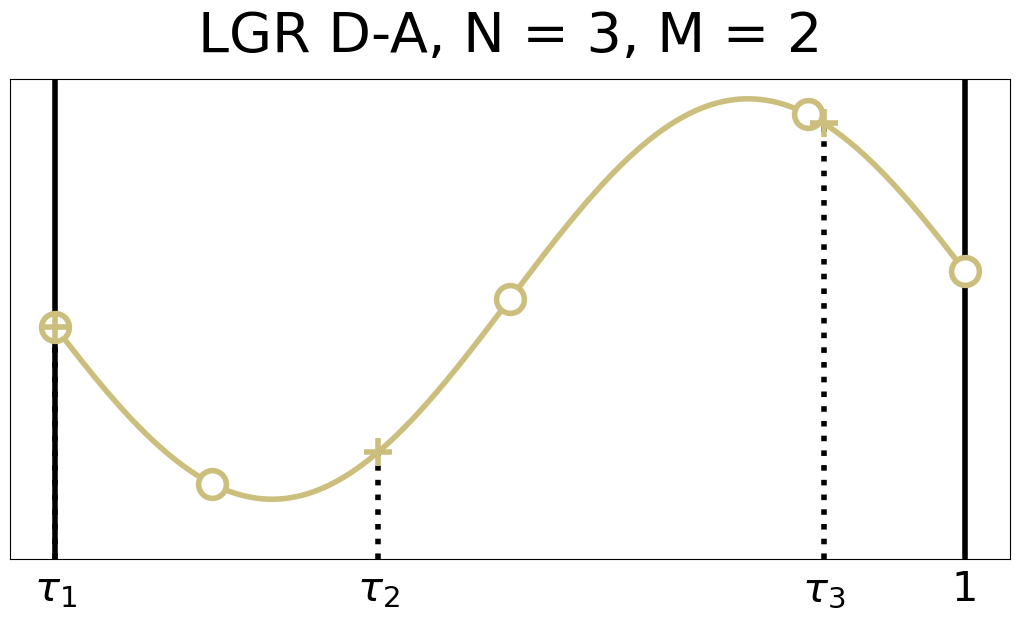

In [22]:
scheme = 'TD_LGR'

plt.figure(figsize=oct_fig_size)
plt.title(sch_to_lab(scheme) + f', N = 3, M = {M}', fontsize=titlesize)
plt.tight_layout(pad=0.0)


plt.vlines([-1,1], [-1.3, -1.3], [1.1,1.1],
          lw = linewidth,
          color = 'k')
plt.vlines(lgr_col, -1.3*np.ones_like(lgr_col), lgr_col_y,
          lw = linewidth,
          color = 'k',
          ls = ':')

plt.plot(t_arr, y_arr, 
         c = sch_to_color(scheme),
         lw = linewidth
        )
plt.plot(lg_bu_nod, lg_bu_nod_y,'o' ,
         mec = sch_to_color(scheme),
         ms = marker_size,
         mfc = 'w',
         mew = linewidth
        )

plt.plot(lgr_col, lgr_col_y,'+' ,
         mec = sch_to_color(scheme),
         ms = marker_size*1,
         mew = linewidth*1,
         mfc = sch_to_color(scheme),
        )
plt.ylim(-1.3, 1.1)
plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left = False,
        labelleft = False,
        labelbottom=True)

x_ticks = np.array(coll_points(N_col, 'LGR')+[1], dtype = float)
x_labels = [r'$\tau_'+str(ii+1)+'$' for ii in range(N_col)] + ['1']
plt.xticks(x_ticks, x_labels, fontsize = 30)

plt.tight_layout(pad=0.0)
if save:
        save_fig(
            problem_name = problem_name,
            graph_name = 'points',
            schemes_printed = [scheme],
            save_format = save_format,
            N = N_col,
            q_counter = None,
        )

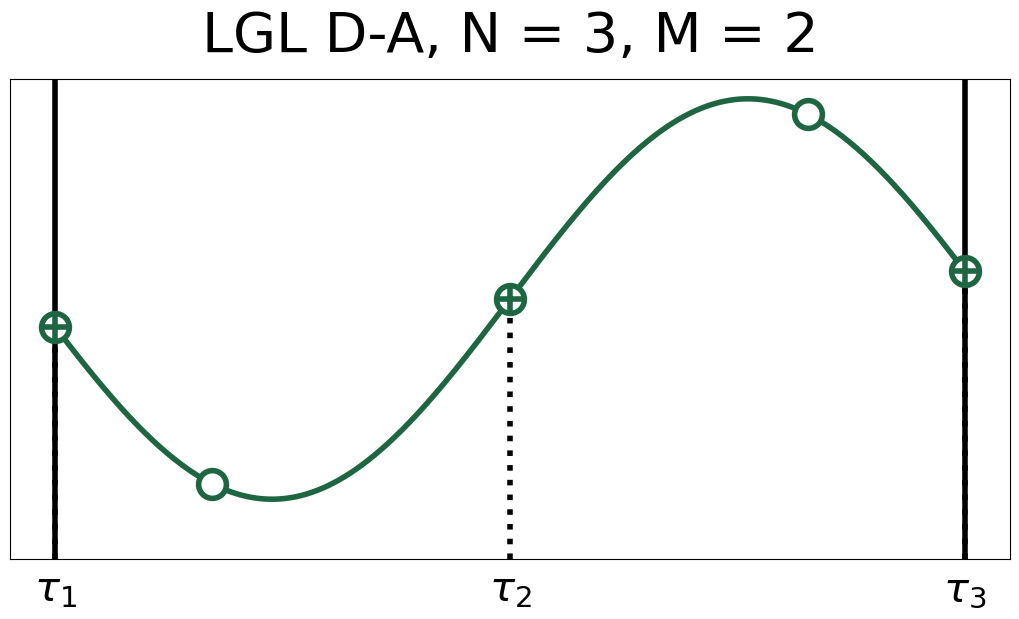

In [23]:
scheme = 'TD_LGL'

plt.figure(figsize=oct_fig_size)
plt.title(sch_to_lab(scheme) + f', N = 3, M = {M}', fontsize=titlesize)
plt.tight_layout(pad=0.0)


plt.vlines([-1,1], [-1.3, -1.3], [1.1,1.1],
          lw = linewidth,
          color = 'k')
plt.vlines(lgl_col, -1.3*np.ones_like(lgl_col), lgl_col_y,
          lw = linewidth,
          color = 'k',
          ls = ':')

plt.plot(t_arr, y_arr, 
         c = sch_to_color(scheme),
         lw = linewidth
        )
plt.plot(lg_bu_nod, lg_bu_nod_y,'o' ,
         mec = sch_to_color(scheme),
         ms = marker_size,
         mfc = 'w',
         mew = linewidth
        )

plt.plot(lgl_col, lgl_col_y,'+' ,
         mec = sch_to_color(scheme),
         ms = marker_size*1,
         mew = linewidth*1,
         mfc = sch_to_color(scheme),
        )
plt.ylim(-1.3, 1.1)
plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left = False,
        labelleft = False,
        labelbottom=True)

x_ticks = np.array(node_points(N_col, 'LGL'), dtype = float)
x_labels = [r'$\tau_'+str(ii+1)+'$' for ii in range(N_col)]
plt.xticks(x_ticks, x_labels, fontsize = 30)

plt.tight_layout(pad=0.0)
if save:
        save_fig(
            problem_name = problem_name,
            graph_name = 'points',
            schemes_printed = [scheme],
            save_format = save_format,
            N = N_col,
            q_counter = None,
        )

# Error of the adaptive refinement methods

In [9]:
def poly_from_roots(*roots):
    pp = 1
    t = symbols('t')
    for root in roots:
        pp *= (t-root)
    return lambdify(t, pp)

In [10]:
from chords.pseudospectral import coll_points, node_points
from chords.util import sch_to_color, oct_fig_size, save_fig

In [11]:
N_col = 3
M = 2

lg_col = np.array(coll_points(N_col, 'LG'), dtype = float)
lgr_col = np.array(coll_points(N_col, 'LGR'), dtype = float)
lgl_col = np.array(coll_points(N_col, 'LGL'), dtype = float)


lg_nod = np.array(node_points(N_col+1, 'LG'), dtype = float)
lg_bu_nod = np.array(node_points(N_col+M, 'LGL'), dtype = float)
lgr_nod = np.array(node_points(N_col+1, 'LGR'), dtype = float)
lgl_nod = np.array(node_points(N_col, 'LGL'), dtype = float)

lg_col_y = np.sin(lg_col*3)
lgr_col_y = np.sin(lgr_col*3)
lgl_col_y = np.sin(lgl_col*3)

lg_nod_y = np.sin(lg_nod*3)
lgr_nod_y = np.sin(lgr_nod*3)
lgl_nod_y = np.sin(lgl_nod*3)
lg_bu_nod_y = np.sin(lg_bu_nod*3)

In [12]:
poly_lg = poly_from_roots(*lg_col)

In [13]:
def f_ej(t):
    p1 = poly_lg(t)
    p2 = poly_lg(t) * t
    s1 = np.sin(t*3)
    return -2 * p1 + p2 + s1

In [14]:
x_lims = (-1.1, 1.1)

t_arr = np.linspace(*x_lims,500)
y_arr = np.sin(t_arr*3)

In [15]:
f_arr = -2 * poly_lg(t_arr) + y_arr

In [16]:
f_arr = f_ej(t_arr)

In [25]:
linewidth = 4
marker_size = 20
titlesize = 40
fontsize = 40
plt.rcParams['axes.titlepad'] = 20
save = True
save_format = 'pdf'

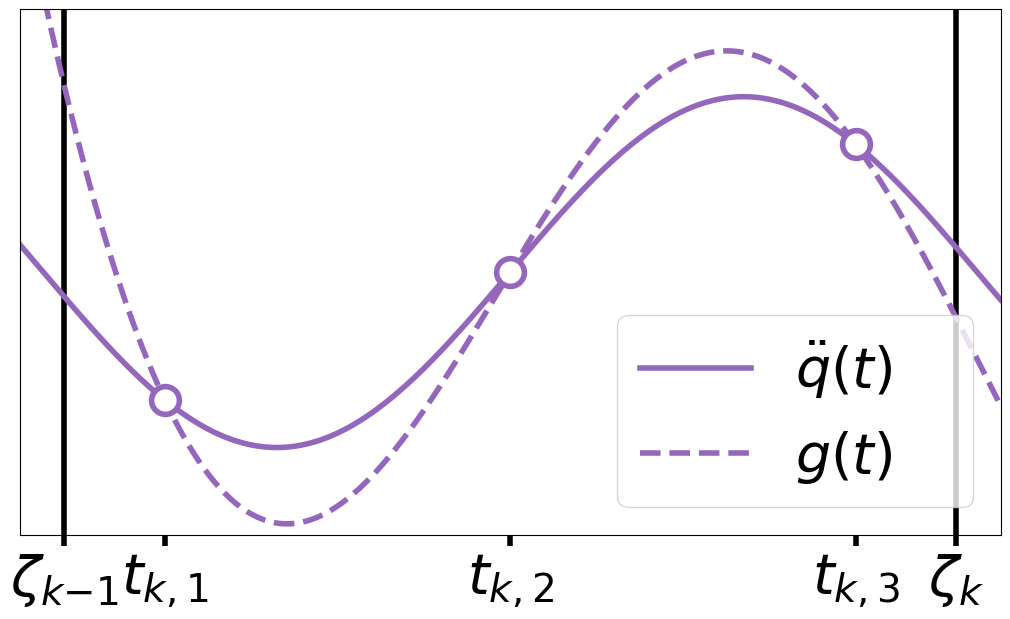

In [27]:
scheme = 'LG'

plt.figure(figsize=oct_fig_size)
#plt.title(sch_to_lab(scheme), fontsize=titlesize)
plt.tight_layout(pad=0.0)
y_lims = (-1.5, 1.5)

plt.vlines([-1,1], 2 * [y_lims[0]], 2*[y_lims[1]],
          lw = linewidth,
          color = 'k')
#plt.vlines(lg_col, -1.3*np.ones_like(lg_col), lg_col_y,
#          lw = linewidth,
#          color = 'k',
#          ls = ':')

plt.plot(t_arr, y_arr, 
         c = sch_to_color(scheme),
         lw = linewidth,
         label = '$\ddot{q}(t)$    '
        )

plt.plot(t_arr, f_arr, 
         c = sch_to_color(scheme),
         lw = linewidth,
         ls = '--',
         label = '$g(t)$'
        )

plt.plot(lg_col, lg_col_y,'o' ,
         mec = sch_to_color(scheme),
         ms = marker_size,
         mfc = 'w',
         mew = linewidth
        )

#plt.plot(lg_col, lg_col_y,'+' ,
#         mec = sch_to_color(scheme),
#         ms = marker_size*1,
#         mew = linewidth*1,
#         mfc = sch_to_color(scheme),
#        )
plt.ylim(y_lims)
plt.xlim(x_lims)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left = False,
    labelleft = False,
    labelbottom=True,
    width = linewidth,
    length = linewidth * 2,
)

x_ticks = np.array(node_points(N_col+1, 'LG')+[1], dtype = float)
x_labels = ['$\zeta_{k{-}1}$'] + [r'$t_{k,'+str(ii+1)+'}$' for ii in range(N_col)] + ['$\zeta_{k}$']
plt.xticks(x_ticks, x_labels, fontsize = fontsize)

plt.legend(fontsize = fontsize)

plt.tight_layout(pad=0.0)
if save:
        save_fig(
            problem_name = problem_name,
            graph_name = 'ph_err_1',
            schemes_printed = [scheme],
            save_format = save_format,
            N = N_col,
            q_counter = None,
        )

In [19]:
lg_col_new = np.array(coll_points(N_col+1, 'LG'), dtype = float)
lg_col_y_new = np.sin(lg_col_new*3)
f_col_new = f_ej(lg_col_new)

In [20]:
f_col_new - lg_col_y_new

array([ 0.34876907, -0.38537429,  0.27339051, -0.13882611])

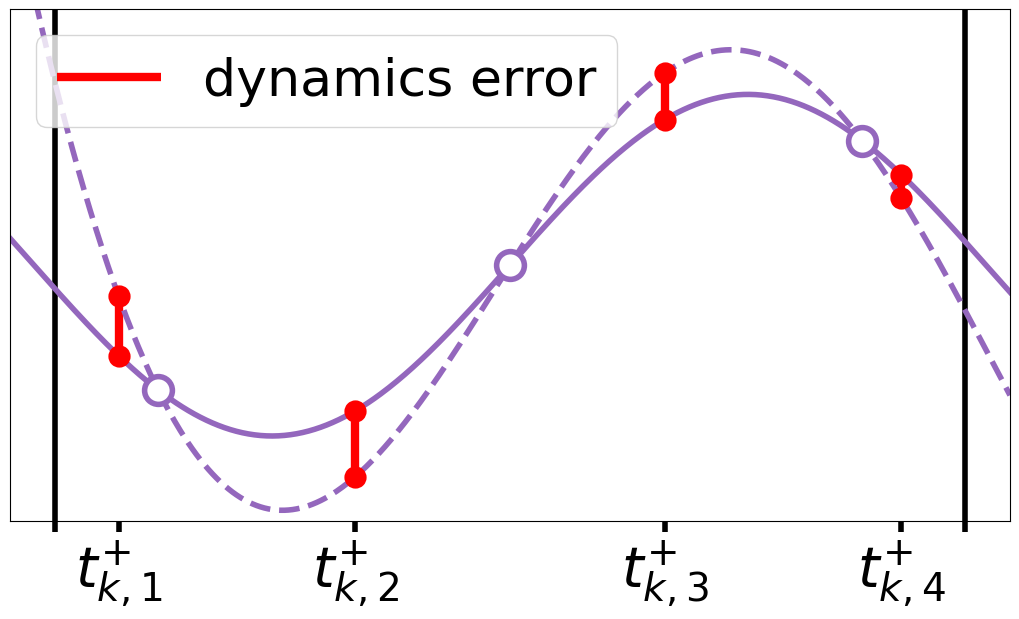

In [33]:
scheme = 'LG'

plt.figure(figsize=oct_fig_size)
#plt.title(sch_to_lab(scheme), fontsize=titlesize)
plt.tight_layout(pad=0.0)
y_lims = (-1.5, 1.5)

plt.vlines([-1,1], 2 * [y_lims[0]], 2*[y_lims[1]],
          lw = linewidth,
          color = 'k')

plt.vlines(lg_col_new, lg_col_y_new, f_col_new,
          lw = linewidth*1.5,
          color = 'r',
          ls = '-',
          label = 'dynamics error'
          )

#for ii in range(N_col+1):
#    plt.arrow(
#        lg_col_new[ii],
#        lg_col_y_new[ii],
#        0,
#        f_col_new[ii] - lg_col_y_new[ii],
#        color = 'r',
#        width = 0.01,
#        length_includes_head=True,
#        head_length = 0.4*abs(f_col_new[ii] - lg_col_y_new[ii]),
#        overhang = 1,
#        #ec = color,
        #lw = linewidth,
#        label = 'dynamics error' if ii==0 else ''
#    )

plt.plot(t_arr, y_arr, 
         c = sch_to_color(scheme),
         lw = linewidth,
         #label = '$\dot{x}(t)$'
        )

plt.plot(t_arr, f_arr, 
         c = sch_to_color(scheme),
         lw = linewidth,
         ls = '--',
         #label = '$f \;(x(t), u(t))$'
        )

plt.plot(lg_col, lg_col_y,'o' ,
         mec = sch_to_color(scheme),
         ms = marker_size,
         mfc = 'w',
         mew = linewidth
        )

plt.plot(lg_col_new, lg_col_y_new,'o' ,
         mec = 'r',
         ms = marker_size*0.6,
         mew = linewidth*1,
         mfc = 'r',
        )
plt.plot(lg_col_new, f_col_new,'o' ,
         mec = 'r',
         ms = marker_size*0.6,
         mew = linewidth*1,
         mfc = 'r',
        )

plt.ylim(y_lims)
plt.xlim(x_lims)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left = False,
    labelleft = False,
    labelbottom=True,
    width = linewidth,
    length = linewidth * 2,
)

x_ticks = np.array(node_points(N_col+2, 'LG')+[1], dtype = float)
x_labels = [''] + [r'$t^{+}_{k,'+str(ii+1)+'}$' for ii in range(N_col+1)] + ['']
plt.xticks(x_ticks, x_labels, fontsize = fontsize)

plt.legend(fontsize = fontsize*0.94, loc = 'upper left')

plt.tight_layout(pad=0.0)
if save:
        save_fig(
            problem_name = problem_name,
            graph_name = 'ph_err_2',
            schemes_printed = [scheme],
            save_format = save_format,
            N = N_col,
            q_counter = None,
        )

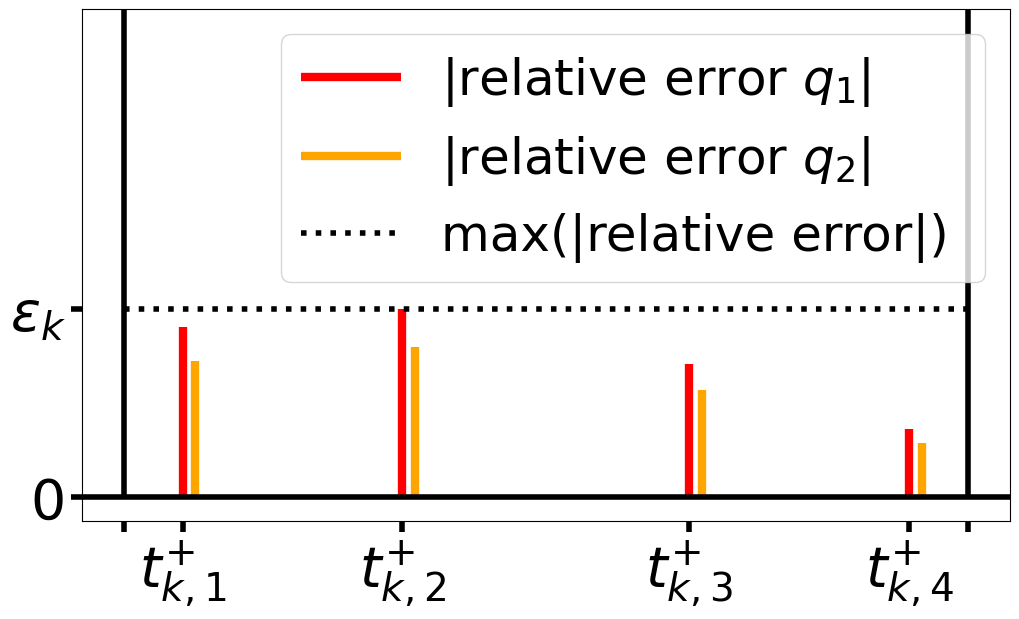

In [37]:
scheme = 'LG'

plt.figure(figsize=oct_fig_size)
#plt.title(sch_to_lab(scheme), fontsize=titlesize)
plt.tight_layout(pad=0.0)
y_lims = (-0.05, 1)

plt.vlines([-1,1], 2 * [0], 2*[y_lims[1]],
        lw = linewidth,
        color = 'k')

plt.vlines(lg_col_new, 0, np.abs(f_col_new - lg_col_y_new),
        lw = linewidth*1.5,
        color = 'r',
        ls = '-',
        label = '|relative error $q_1$| '
        )

plt.vlines(lg_col_new+0.03, 0, np.abs(f_col_new - lg_col_y_new)*0.8,
        lw = linewidth*1.5,
        color = 'orange',
        ls = '-',
        label = '|relative error $q_2$| '
        )

plt.hlines(0, x_lims[0], x_lims[1],
        lw = linewidth,
        color = 'k')

plt.hlines(np.max(np.abs(f_col_new - lg_col_y_new)), -1, 1,
        lw = linewidth,
        color = 'k',
        ls = ':',
        label = 'max(|relative error|) '
        )

#for ii in range(N_col+1):
#    plt.arrow(
#        lg_col_new[ii],
#        lg_col_y_new[ii],
#        0,
#        f_col_new[ii] - lg_col_y_new[ii],
#        color = 'r',
#        width = 0.01,
#        length_includes_head=True,
#        head_length = 0.4*abs(f_col_new[ii] - lg_col_y_new[ii]),
#        overhang = 1,
#        #ec = color,
        #lw = linewidth,
#        label = 'dynamics error' if ii==0 else ''
#    )



plt.ylim(y_lims)
plt.xlim(x_lims)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left = True,
    labelleft = True,
    labelbottom=True,
    width = linewidth,
    length = linewidth * 2,
)

x_ticks = np.array(node_points(N_col+2, 'LG')+[1], dtype = float)
x_labels = [''] + [r'$t^{+}_{k,'+str(ii+1)+'}$' for ii in range(N_col+1)] + ['']
plt.xticks(x_ticks, x_labels, fontsize = fontsize)

y_ticks = np.array([0, np.max(np.abs(f_col_new - lg_col_y_new))])
y_labels = [0, r'$\varepsilon_k$']
plt.yticks(y_ticks, y_labels, fontsize = fontsize)


plt.legend(fontsize = fontsize*0.9)

plt.tight_layout(pad=0.0)
if save:
        save_fig(
            problem_name = problem_name,
            graph_name = 'ph_err_3',
            schemes_printed = [scheme],
            save_format = save_format,
            N = N_col,
            q_counter = None,
        )